In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary

from tqdm import trange

In [2]:
def plot_fault_counts(fault_params_list):
    """Plots bar chart of total, normal, and inverse fault counts."""
    if not fault_params_list:
        print("No fault data to plot counts.")
        # plt.close('all') # Close potentially empty figure if needed
        return None # Return None if no plot is generated

    normal_count = sum(1 for f in fault_params_list if f['fault_type'] == 'Normal')
    inverse_count = sum(1 for f in fault_params_list if f['fault_type'] == 'Inverse')
    total_count = len(fault_params_list)

    labels = ['Total', 'Normal', 'Inverse']
    counts = [total_count, normal_count, inverse_count]

    fig, ax = plt.subplots(figsize=(6, 5)) # Smaller figure for bar chart
    ax.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_ylabel('Number of Faults')
    ax.set_title('Fault Type Distribution Across All Cubes')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Add text labels on bars
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.02, str(count), ha='center')
    plt.tight_layout()
    return fig # Return figure object


In [3]:
def plot_histogram(data, title, xlabel, bins='auto'):
    """Plots a histogram."""
    if not data or (isinstance(data, list) and not any(x is not None for x in data)):
        print(f"No data to plot histogram for '{title}'.")
        # plt.close('all') # Close potentially empty figure if needed
        return None # Return None if no plot is generated

    # Filter out None values if present (e.g., for noise)
    filtered_data = [x for x in data if x is not None]
    if not filtered_data:
         print(f"No valid (non-None) data to plot histogram for '{title}'.")
         # plt.close('all') # Close potentially empty figure if needed
         return None

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(filtered_data, bins=bins, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    return fig # Return figure object


In [4]:
def plot_rose_diagram(strikes_deg, title="Fault Strike Angle Distribution (Rose Diagram)"):
    """Plots a rose diagram for strike angles."""
    if not strikes_deg:
        print("No strike data to plot for rose diagram.")
        # plt.close('all') # Close potentially empty figure if needed
        return None # Return None if no plot is generated

    # Convert degrees to radians
    strikes_rad = np.radians(strikes_deg)

    # Define bins (e.g., 20-degree bins)
    # Use 18 bins for 20 degree intervals up to 360
    num_bins = 18
    bin_edges_deg = np.linspace(0, 360, num_bins + 1)
    bin_edges_rad = np.radians(bin_edges_deg)

    # Use histogram to count occurrences in each bin
    counts, _ = np.histogram(strikes_rad, bins=bin_edges_rad)

    # Calculate angles for the center of the bins for plotting position
    bin_centers_rad = bin_edges_rad[:-1] + np.diff(bin_edges_rad)/2

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

    # Plot bars. Using align='center' centers the bar on the angle.
    width = np.diff(bin_edges_rad)[0] # Width of each bar in radians
    ax.bar(bin_centers_rad, counts, width=width, bottom=0.0, align='center', alpha=0.7, color='skyblue', edgecolor='black')

    # Set titles and labels
    ax.set_title(title, va='bottom', y=1.1) # Adjust title position

    # Set 0 degrees to North (top), clockwise direction (standard for strike plots)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # Set r-label location
    ax.set_rlabel_position(135) # Move radial labels away from bars

    # Improve grid and ticks - show ticks every 30 degrees
    ax.set_xticks(np.radians(np.arange(0, 360, 30)))
    ax.set_xticklabels([f'{i}°' for i in np.arange(0, 360, 30)])
    ax.grid(True)

    plt.tight_layout()
    return fig # Return figure object

---

# Data Generation

In [5]:
# ─── 0) User picks parameters ────────────────────────────────────────────
mask_mode    = 0 # 0 binary (0, 1) | 1 Multiclass (0, 1, 2), normal and inverse faults
num_pairs    = 10
cube_size    = 128
ricker_freq = (5, 35)      # Hz or (min, max)
seismic_noise = (0.1, 0.5)      # None | float | (min, max)
ricker_dt    = 0.002
wavelet_len  = 0.2        # s
num_gauss    = (2,10)     # int or (min, max)
num_faults = (0,4)       # int or (min, max) faults per cube
max_disp   = (75, 100)   # int or (min, max) max displacement magnitude per cube
strike     = (0,360)      # deg or (min, max) strike angle per fault
dip        = (35,80) # deg or (min, max) dip angle per fault
output_format = "dat" # npy, npz, or dat

In [6]:
# ─── 1) Call your script (passing parameters from notebook variables) ─────────────────
script = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py"
base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output") # Define base_out here

print(f"Running script: {script}")
print(f"Output directory: {base_out}")

cmd = [
    "python", script,
    "--num-pairs",     str(num_pairs),
    "--size",          str(cube_size),
    "--dt",            str(ricker_dt),
    "--length",        str(wavelet_len),
    "--mask-mode",     str(mask_mode),
    "--format",        output_format,
    "--output-dir",    base_out,
]


Running script: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py
Output directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output


In [7]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

append_param_to_cmd(cmd, "freq", ricker_freq)
append_param_to_cmd(cmd, "num-gaussians", num_gauss)
append_param_to_cmd(cmd, "noise", seismic_noise)
append_param_to_cmd(cmd, "faults", num_faults)
append_param_to_cmd(cmd, "max-disp", max_disp)
append_param_to_cmd(cmd, "strike", strike)
append_param_to_cmd(cmd, "dip", dip)

In [8]:
print("\nCommand to run:")
print(" ".join(cmd)) # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")


Command to run:
python /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py --num-pairs 10 --size 128 --dt 0.002 --length 0.2 --mask-mode 0 --format dat --output-dir /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --faults 0,4 --max-disp 75,100 --strike 0,360 --dip 35,80

Running subprocess...
=== STDOUT ===
 Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/seismic
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/mask

Starting data generation for 10 pairs...
Generating cube 1/10...
Generating cube 2/10...
Generating cube 3/10...
Generating cube 4/10...
Generating cube 5/10...
Generating cube 6/10...
Generating cube 7/10...
Generating cube 8/10...
Generating cube 9/10...
Generating cube 10/10...

[2025-06-30 07:21:23] Generation complete.
 • seismic → /

In [9]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────
seismic_dir = os.path.join(base_out, "seismic")
mask_dir    = os.path.join(base_out, "mask")
stats_file_path = os.path.join(base_out, "stats_data.json") # Path to the saved stats file

In [10]:
# Check if the expected number of files were generated
files = []
if os.path.exists(seismic_dir):
    files   = sorted(f for f in os.listdir(seismic_dir) if f.endswith((".npy", ".npz", ".dat"))) # Check all formats
    n_files = len(files)
    # assert n_files == num_pairs, f"Mismatch: Expected {num_pairs} files, found {n_files} in {seismic_dir}"
    if n_files != num_pairs:
         print(f"Warning: Mismatch in generated files ({n_files}) and requested pairs ({num_pairs}). Check script output.")
else:
    n_files = 0
    print(f"Warning: Seismic output directory not found: {seismic_dir}")

In [11]:
# Load the stats data
all_fault_params = []
cube_level_params = []
if os.path.exists(stats_file_path):
    print(f"\nLoading statistics from {stats_file_path}")
    try:
        with open(stats_file_path, 'r') as f:
            stats_data = json.load(f)
        all_fault_params = stats_data.get('all_fault_params', []) # Use .get for safety
        cube_level_params = stats_data.get('cube_level_params', []) # Use .get for safety
        print("Statistics data loaded successfully.")
    except Exception as e:
        print(f"Error loading statistics data: {e}")
        # Data lists remain empty
else:
    print(f"\nWarning: Statistics file not found: {stats_file_path}. Cannot generate stats plots.")
    # Data lists remain empty


Loading statistics from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/stats_data.json
Statistics data loaded successfully.


In [12]:
# ─── 3) Display Statistics and Plots (Using loaded data) ─────────────────────────────────────────────────
print("\n--- Displaying Statistics and Plots ---")

# Collect data into lists for plotting and stats from loaded data
cube_freqs = [c['freq'] for c in cube_level_params if 'freq' in c]
cube_noise_sigmas = [c['noise_sigma'] for c in cube_level_params if 'noise_sigma' in c and c['noise_sigma'] is not None]
cube_gaussian_counts = [c['num_gaussians'] for c in cube_level_params if 'num_gaussians' in c]
# cube_num_faults_generated = [c['num_faults_generated'] for c in cube_level_params if 'num_faults_generated' in c] # Not directly plotted, but used in summary
cube_max_disps_used = [c['max_disp_used'] for c in cube_level_params if 'max_disp_used' in c] # Displacement magnitude used per cube

# Fault-specific parameters (only for faults that were actually generated)
# Use .get with default 0 or None for safety in case keys are missing
fault_disp_mags = [f.get('disp_magnitude_per_cube', 0) for f in all_fault_params]
fault_vertical_disps = [f.get('vertical_disp_component', 0) for f in all_fault_params]
fault_strikes = [f.get('strike', 0) for f in all_fault_params]
fault_dips = [f.get('dip', 0) for f in all_fault_params]
fault_types = [f.get('fault_type', 'Unknown') for f in all_fault_params]

# Print Summary Statistics
print("\n--- Summary Statistics ---")

total_faults = len(all_fault_params)
normal_faults = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
inverse_faults = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')

print(f"Total cubes generated: {len(cube_level_params)} (requested {num_pairs})")
print(f"Cubes generated with >= 1 fault: {sum(1 for c in cube_level_params if c.get('num_faults_generated', 0) > 0)}")
print(f"Total faults generated across all cubes: {total_faults}")
print(f"  Normal faults: {normal_faults} ({normal_faults/total_faults*100:.1f}%)" if total_faults > 0 else "  Normal faults: 0")
print(f"  Inverse faults: {inverse_faults} ({inverse_faults/total_faults*100:.1f}%)" if total_faults > 0 else "  Inverse faults: 0")

if cube_max_disps_used:
    min_disp = np.min(cube_max_disps_used)
    max_disp = np.max(cube_max_disps_used)
    avg_disp = np.mean(cube_max_disps_used)
    print(f"Max Displacement Parameter Per Cube: Min={min_disp:.2f}, Max={max_disp:.2f}, Avg={avg_disp:.2f} grid units (Calculated over all {len(cube_max_disps_used)} cubes)")
    # If you only want stats for cubes that *actually* got faults:
    cube_max_disps_with_faults = [c['max_disp_used'] for c in cube_level_params if c.get('num_faults_generated', 0) > 0]
    if cube_max_disps_with_faults:
        min_disp_nf = np.min(cube_max_disps_with_faults)
        max_disp_nf = np.max(cube_max_disps_with_faults)
        avg_disp_nf = np.mean(cube_max_disps_with_faults)
        print(f"Max Displacement Parameter Per Cube (where faults exist): Min={min_disp_nf:.2f}, Max={max_disp_nf:.2f}, Avg={avg_disp_nf:.2f} grid units (Calculated over {len(cube_max_disps_with_faults)} cubes with faults)")

else:
     print("No cube-level displacement statistics available (no cubes generated?).")
     
if cube_freqs:
    min_freq = np.min(cube_freqs)
    max_freq = np.max(cube_freqs)
    avg_freq = np.mean(cube_freqs)
    print(f"Ricker Frequency Per Cube: Min={min_freq:.2f}, Max={max_freq:.2f}, Avg={avg_freq:.2f} Hz")
else:
     print("No Ricker frequency statistics available (no cubes generated?).")
     
if cube_noise_sigmas:
    min_noise = np.min(cube_noise_sigmas)
    max_noise = np.max(cube_noise_sigmas)
    avg_noise = np.mean(cube_noise_sigmas)
    print(f"Seismic Noise Sigma Per Cube: Min={min_noise:.3f}, Max={max_noise:.3f}, Avg={avg_noise:.3f}")
elif seismic_noise is None:
    print("Seismic Noise: Not applied.")
else:
    print(f"Seismic Noise: Applied as fixed value or range, but no noise sigmas recorded. Check generation/loading.") # Should not happen with current code

if cube_gaussian_counts:
    min_gauss = np.min(cube_gaussian_counts)
    max_gauss = np.max(cube_gaussian_counts)
    avg_gauss = np.mean(cube_gaussian_counts)
    print(f"Number of Gaussians Per Cube: Min={min_gauss}, Max={max_gauss}, Avg={avg_gauss:.2f}")
else:
     print("No Number of Gaussians statistics available (no cubes generated?).")
     
if fault_strikes:
    min_strike = np.min(fault_strikes)
    max_strike = np.max(fault_strikes)
    avg_strike = np.mean(fault_strikes)
    print(f"Fault Strike Angle (Per Fault): Min={min_strike:.2f}, Max={max_strike:.2f}, Avg={avg_strike:.2f} degrees")
else:
     print("No faults generated to calculate strike statistics.")
     
if fault_dips:
    min_dip = np.min(fault_dips)
    max_dip = np.max(fault_dips)
    avg_dip = np.mean(fault_dips)
    print(f"Fault Dip Angle (Per Fault): Min={min_dip:.2f}, Max={max_dip:.2f}, Avg={avg_dip:.2f} degrees")
else:
     print("No faults generated to calculate dip statistics.")



--- Displaying Statistics and Plots ---

--- Summary Statistics ---
Total cubes generated: 10 (requested 10)
Cubes generated with >= 1 fault: 7
Total faults generated across all cubes: 16
  Normal faults: 0 (0.0%)
  Inverse faults: 0 (0.0%)
Max Displacement Parameter Per Cube: Min=76.00, Max=99.00, Avg=89.90 grid units (Calculated over all 10 cubes)
Max Displacement Parameter Per Cube (where faults exist): Min=76.00, Max=99.00, Avg=90.29 grid units (Calculated over 7 cubes with faults)
Ricker Frequency Per Cube: Min=8.18, Max=34.73, Avg=20.77 Hz
Seismic Noise Sigma Per Cube: Min=0.177, Max=0.490, Avg=0.306
Number of Gaussians Per Cube: Min=3, Max=10, Avg=6.80
Fault Strike Angle (Per Fault): Min=0.48, Max=357.32, Avg=182.08 degrees
Fault Dip Angle (Per Fault): Min=36.55, Max=77.93, Avg=52.97 degrees


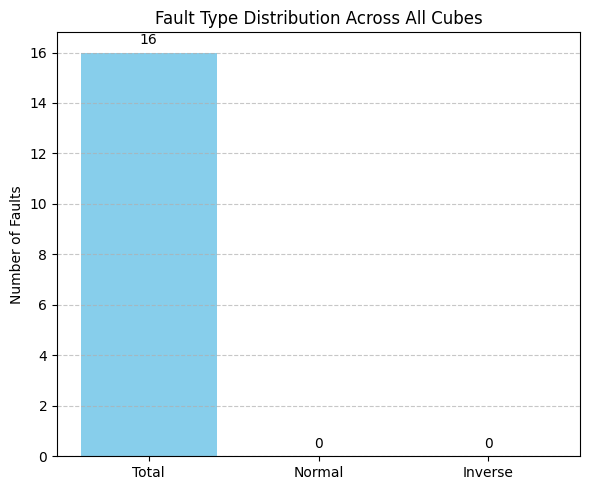

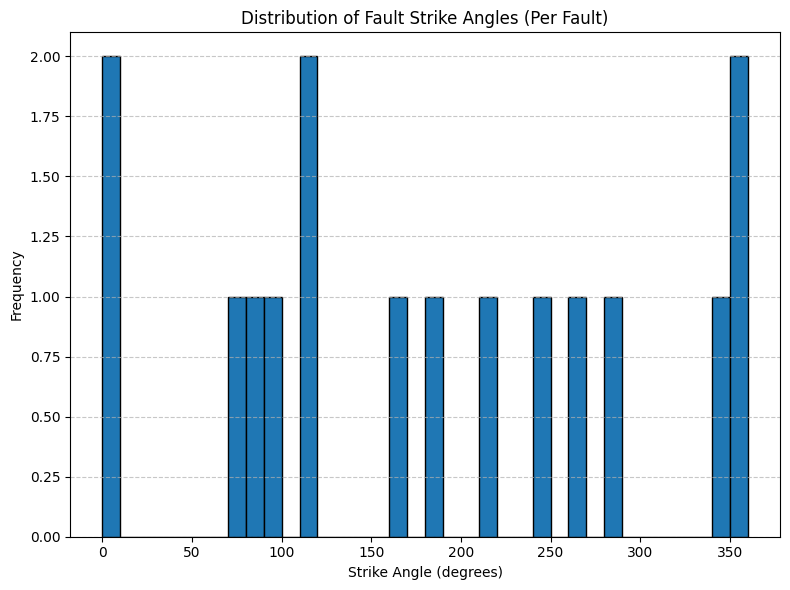

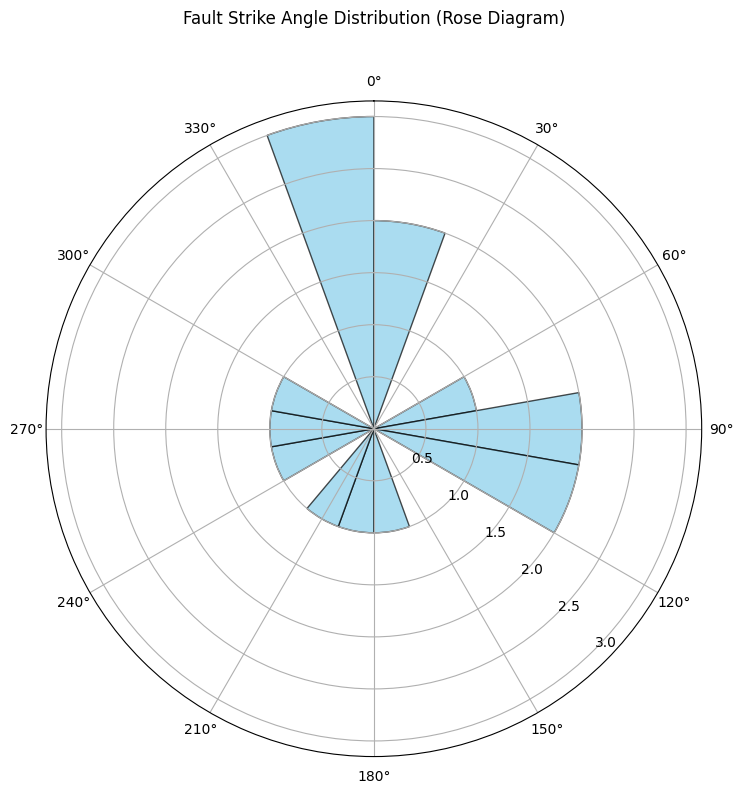

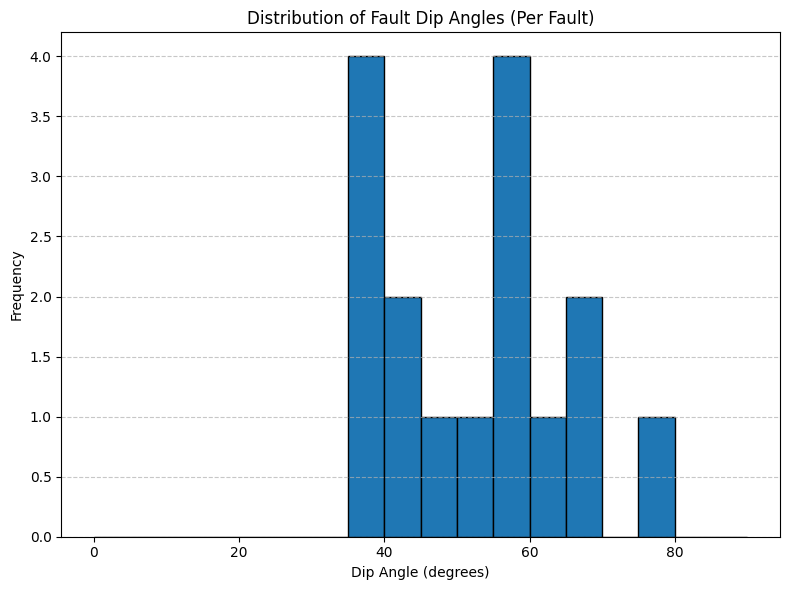

In [13]:
# --- Generate and Show Statistics Plots ---

if total_faults > 0:
    # 1. Fault Counts (Total, Normal, Inverse)
    plot_fault_counts(all_fault_params) # Uses the list of fault params directly

    # 6. Strike Histogram and Rose Diagram (per fault)
    plot_histogram(fault_strikes, 'Distribution of Fault Strike Angles (Per Fault)', 'Strike Angle (degrees)', bins=np.arange(0, 361, 10)) # 10 degree bins
    plot_rose_diagram(fault_strikes)

    # 7. Dip Histogram (per fault)
    plot_histogram(fault_dips, 'Distribution of Fault Dip Angles (Per Fault)', 'Dip Angle (degrees)', bins=np.arange(0, 91, 5)) # 5 degree bins from 0 to 90
else:
    print("\nSkipping fault-specific plots as no faults were generated.")

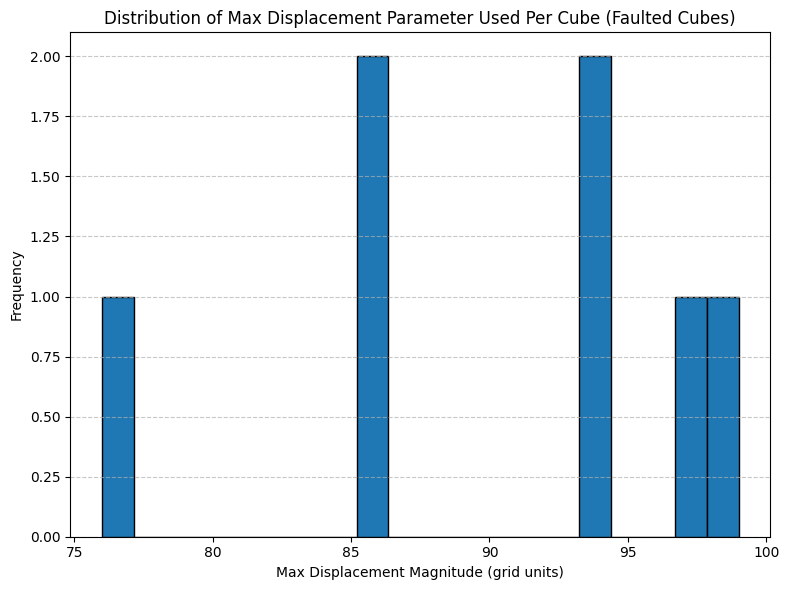

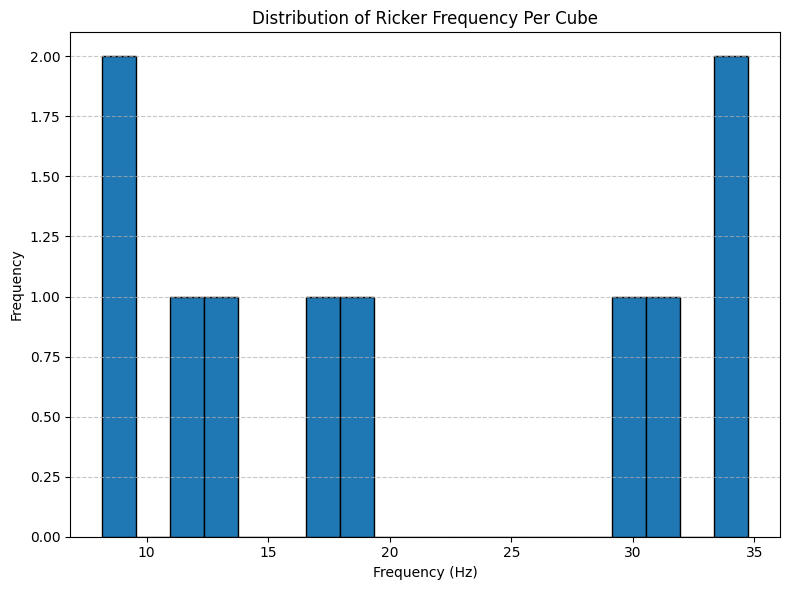

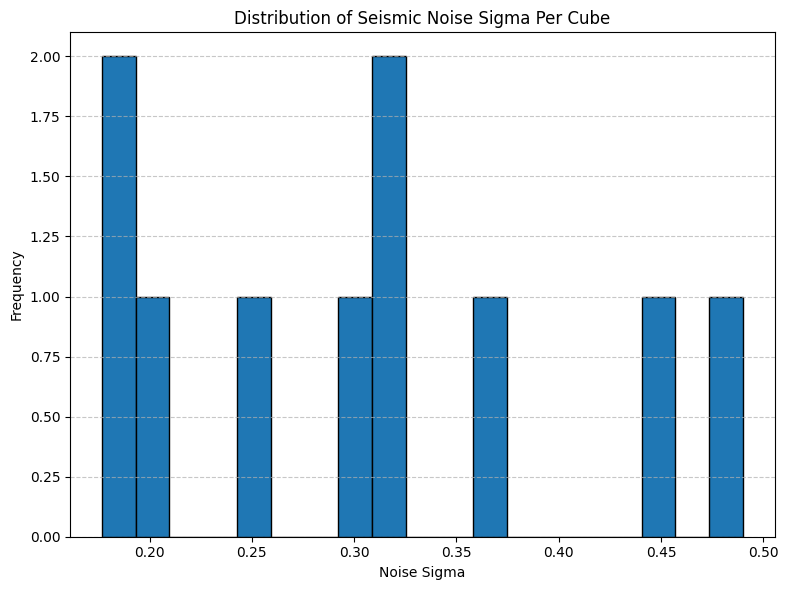

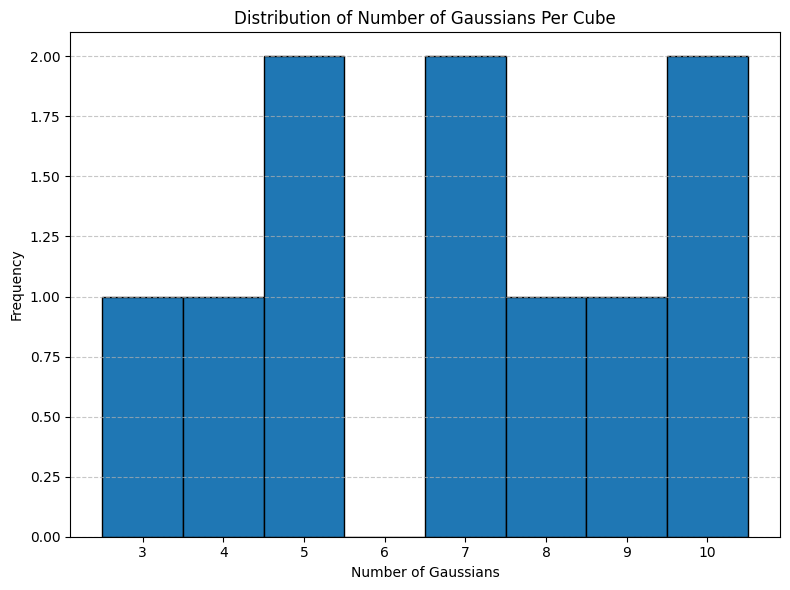

In [14]:
if cube_level_params: # Plot cube-level stats only if cubes were generated
    # 2. Displacement Magnitude Histogram (Using the max_disp value applied per cube where faults exist)
    # Use integer bins for integer displacements
    cube_max_disps_with_faults = [c['max_disp_used'] for c in cube_level_params if c.get('num_faults_generated', 0) > 0]
    # Determine bins based on the actual range, if data exists
    bins_disp = 'auto'
    if cube_max_disps_with_faults:
        min_val = min(cube_max_disps_with_faults)
        max_val = max(cube_max_disps_with_faults)
        # If the original max_disp parameter was int or int range, use integer bins
        if isinstance(max_disp, int) or (isinstance(max_disp, tuple) and all(isinstance(x, int) for x in max_disp)):
             bins_disp = np.arange(min_val-0.5, max_val+1.5, 1)
        else: # Otherwise, use automatic or default number of bins
             bins_disp = 20 # Example fixed bin count for float range
    plot_histogram(cube_max_disps_with_faults, 'Distribution of Max Displacement Parameter Used Per Cube (Faulted Cubes)', 'Max Displacement Magnitude (grid units)', bins=bins_disp)


    # 3. Ricker Frequency Histogram
    # Determine appropriate bins for frequencies
    bins_freq = 'auto'
    if cube_freqs:
        min_val, max_val = min(cube_freqs), max(cube_freqs)
        bins_freq = np.linspace(min_val, max_val, 20) # 20 bins across range
    plot_histogram(cube_freqs, 'Distribution of Ricker Frequency Per Cube', 'Frequency (Hz)', bins=bins_freq)

    # 4. Seismic Noise Histogram
    # Determine appropriate bins for noise
    bins_noise = 'auto'
    if cube_noise_sigmas:
         min_val, max_val = min(cube_noise_sigmas), max(cube_noise_sigmas)
         bins_noise = np.linspace(min_val, max_val, 20) # 20 bins across range
    plot_histogram(cube_noise_sigmas, 'Distribution of Seismic Noise Sigma Per Cube', 'Noise Sigma', bins=bins_noise)


    # 5. Num Gaussians Histogram
    # Determine appropriate bins for gaussians (integers)
    bins_gauss = 'auto'
    if cube_gaussian_counts:
        min_val = min(cube_gaussian_counts)
        max_val = max(cube_gaussian_counts)
        # If the original num_gauss parameter was int or int range, use integer bins
        if isinstance(num_gauss, int) or (isinstance(num_gauss, tuple) and all(isinstance(x, int) for x in num_gauss)):
             bins_gauss = np.arange(min_val-0.5, max_val+1.5, 1)
        else:
             bins_gauss = 20 # Example fixed bin count
    plot_histogram(cube_gaussian_counts, 'Distribution of Number of Gaussians Per Cube', 'Number of Gaussians', bins=bins_gauss)
else:
    print("\nSkipping cube-level plots as no cubes were generated.")



---

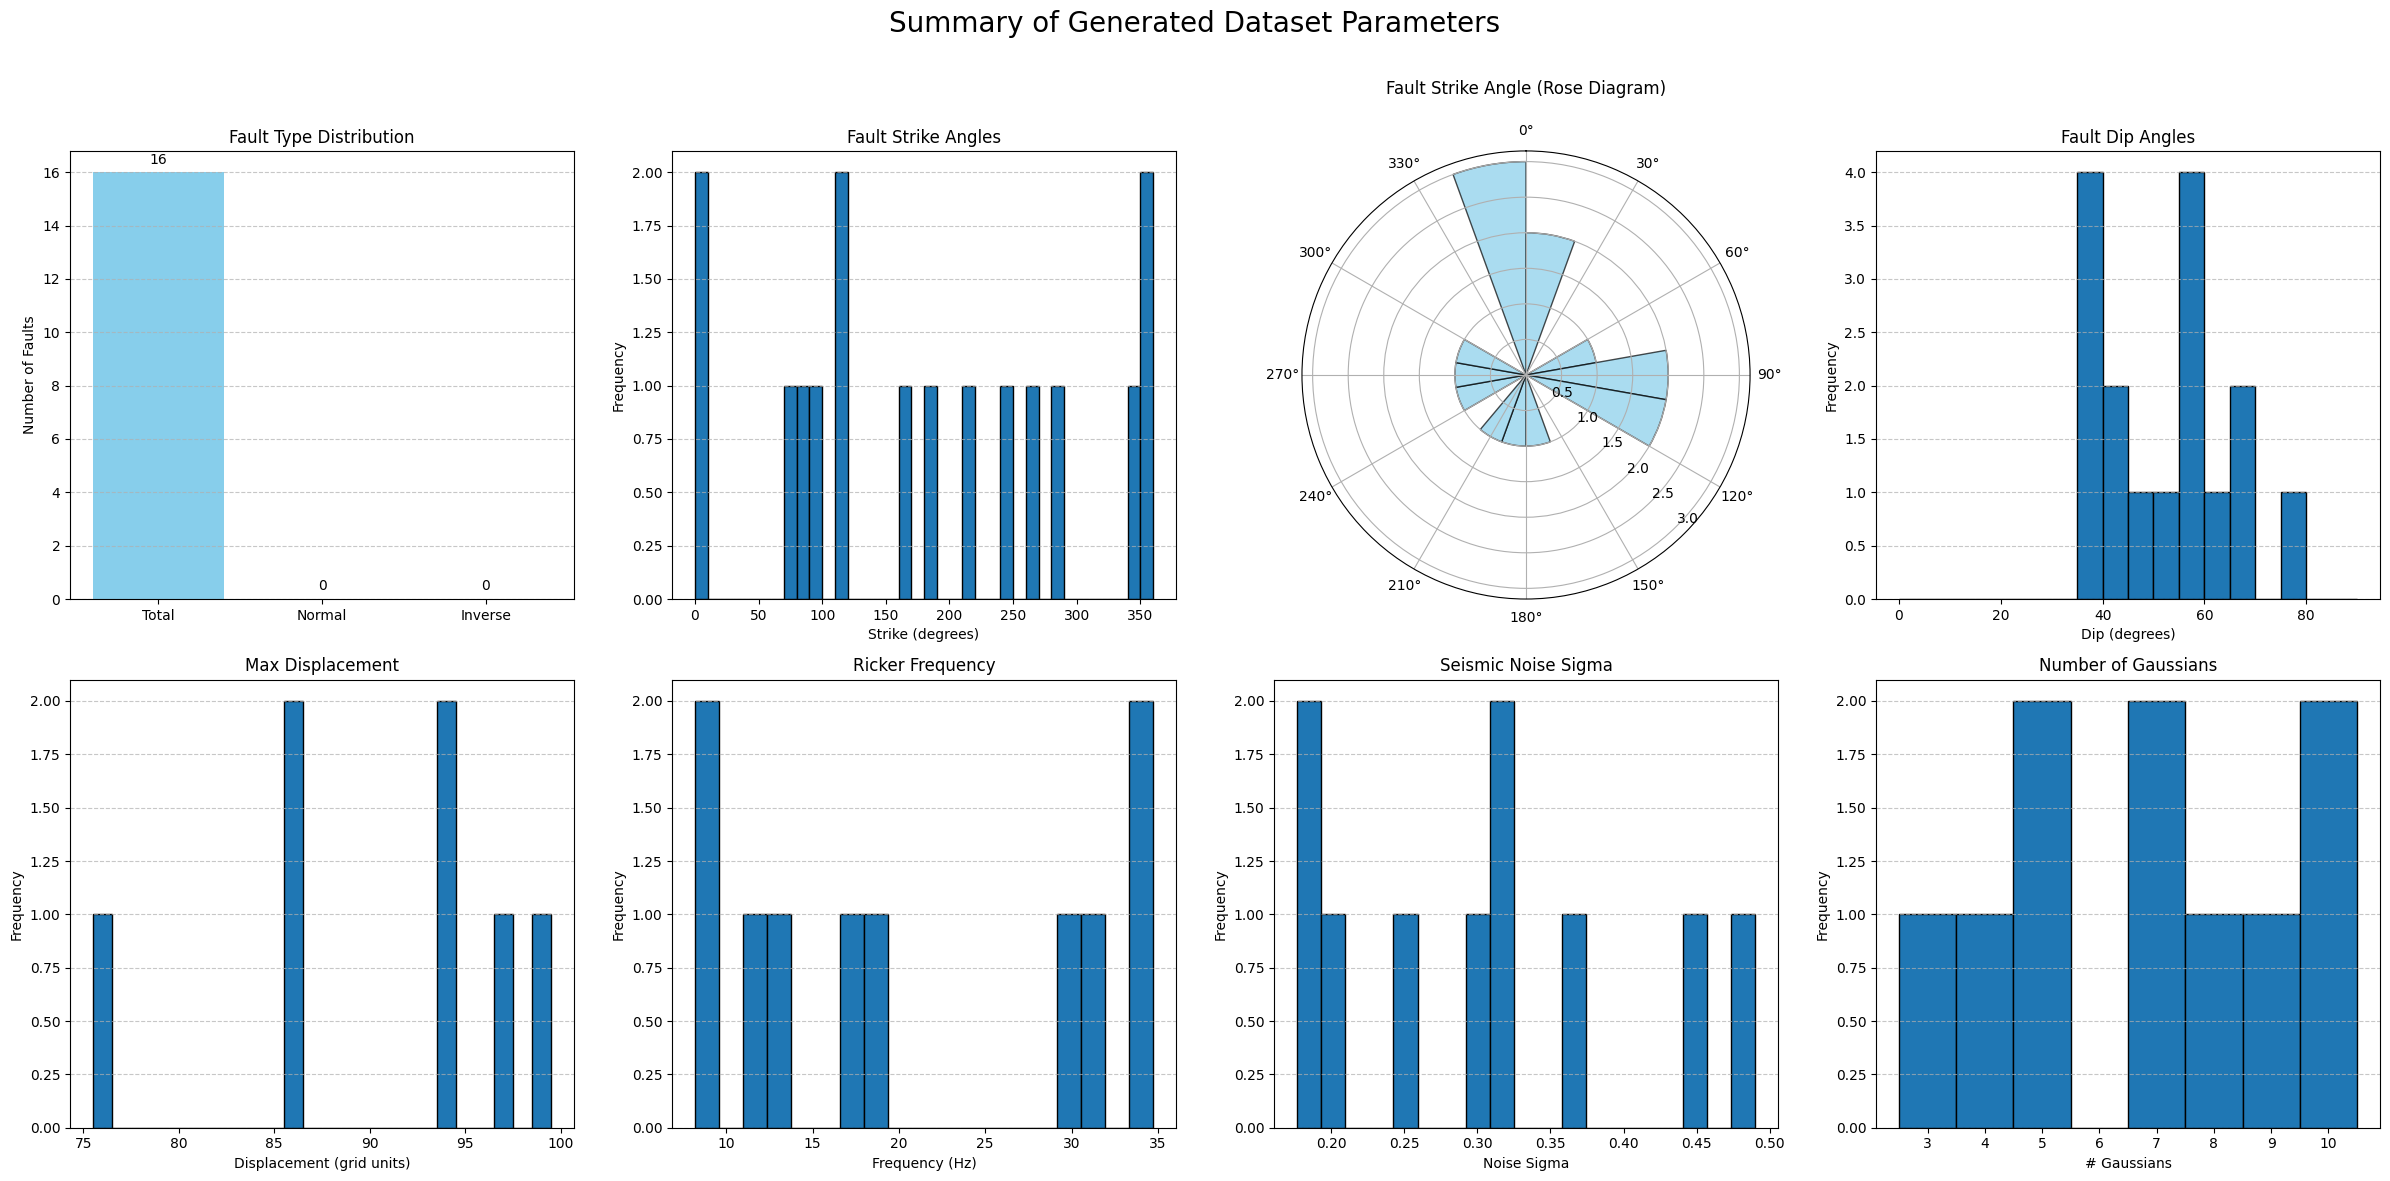

In [25]:
def plot_fault_counts(fault_params_list, ax):
    """Plots bar chart of total, normal, and inverse fault counts on a given axis."""
    if not fault_params_list:
        print("No fault data to plot counts.")
        ax.text(0.5, 0.5, 'No Fault Data', ha='center', va='center')
        ax.set_title('Fault Type Distribution')
        ax.set_xticks([])
        ax.set_yticks([])
        return

    normal_count = sum(1 for f in fault_params_list if f['fault_type'] == 'Normal')
    inverse_count = sum(1 for f in fault_params_list if f['fault_type'] == 'Inverse')
    total_count = len(fault_params_list)

    labels = ['Total', 'Normal', 'Inverse']
    counts = [total_count, normal_count, inverse_count]

    ax.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_ylabel('Number of Faults')
    ax.set_title('Fault Type Distribution')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.02, str(count), ha='center')

def plot_histogram(data, title, xlabel, ax, bins='auto'):
    """Plots a histogram on a given axis."""
    if not data or (isinstance(data, list) and not any(x is not None for x in data)):
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Frequency')
        return

    filtered_data = [x for x in data if x is not None]
    if not filtered_data:
         ax.text(0.5, 0.5, 'No Valid Data', ha='center', va='center')
         ax.set_title(title)
         ax.set_xlabel(xlabel)
         ax.set_ylabel('Frequency')
         return

    ax.hist(filtered_data, bins=bins, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

def plot_rose_diagram(strikes_deg, ax, title="Fault Strike Angle (Rose Diagram)"):
    """Plots a rose diagram for strike angles on a given polar axis."""
    if not strikes_deg:
        ax.text(0.5, 0.5, 'No Strike Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title, va='bottom', y=1.1)
        return

    strikes_rad = np.radians(strikes_deg)
    num_bins = 18
    bin_edges_rad = np.linspace(0, 2 * np.pi, num_bins + 1)
    counts, _ = np.histogram(strikes_rad, bins=bin_edges_rad)
    bin_centers_rad = bin_edges_rad[:-1] + np.diff(bin_edges_rad) / 2
    width = np.diff(bin_edges_rad)[0]
    
    ax.bar(bin_centers_rad, counts, width=width, bottom=0.0, align='center', alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(title, va='bottom', y=1.1)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(135)
    ax.set_xticks(np.radians(np.arange(0, 360, 30)))
    ax.set_xticklabels([f'{i}°' for i in np.arange(0, 360, 30)])
    ax.grid(True)

# --- Generate and Show Statistics Plots in a 2x4 Grid ---
fig = plt.figure(figsize=(24, 12))
fig.suptitle('Summary of Generated Dataset Parameters', fontsize=20)

gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2], projection='polar')
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

# --- Plot Fault-Specific Data ---
if total_faults > 0:
    plot_fault_counts(all_fault_params, ax=ax1)
    plot_histogram(fault_strikes, 'Fault Strike Angles', 'Strike (degrees)', ax=ax2, bins=np.arange(0, 361, 10))
    plot_rose_diagram(fault_strikes, ax=ax3)
    plot_histogram(fault_dips, 'Fault Dip Angles', 'Dip (degrees)', ax=ax4, bins=np.arange(0, 91, 5))
else:
    for i, ax in enumerate([ax1, ax2, ax3, ax4]):
        ax.text(0.5, 0.5, 'No Faults Generated', ha='center', va='center')
        ax.set_title(['Fault Counts', 'Strike', 'Strike Rose', 'Dip'][i])

# --- Plot Cube-Level Data ---
if cube_level_params:
    # Determine bins for displacement
    cube_max_disps_with_faults = [c['max_disp_used'] for c in cube_level_params if c.get('num_faults_generated', 0) > 0]
    bins_disp = np.arange(min(cube_max_disps_with_faults)-0.5, max(cube_max_disps_with_faults)+1.5, 1) if cube_max_disps_with_faults else 'auto'
    plot_histogram(cube_max_disps_with_faults, 'Max Displacement', 'Displacement (grid units)', ax=ax5, bins=bins_disp)

    # Determine bins for frequency
    bins_freq = np.linspace(min(cube_freqs), max(cube_freqs), 20) if cube_freqs else 'auto'
    plot_histogram(cube_freqs, 'Ricker Frequency', 'Frequency (Hz)', ax=ax6, bins=bins_freq)

    # Determine bins for noise
    bins_noise = np.linspace(min(cube_noise_sigmas), max(cube_noise_sigmas), 20) if cube_noise_sigmas else 'auto'
    plot_histogram(cube_noise_sigmas, 'Seismic Noise Sigma', 'Noise Sigma', ax=ax7, bins=bins_noise)

    # Determine bins for gaussians
    bins_gauss = np.arange(min(cube_gaussian_counts)-0.5, max(cube_gaussian_counts)+1.5, 1) if cube_gaussian_counts else 'auto'
    plot_histogram(cube_gaussian_counts, 'Number of Gaussians', '# Gaussians', ax=ax8, bins=bins_gauss)
else:
    for i, ax in enumerate([ax5, ax6, ax7, ax8]):
        ax.text(0.5, 0.5, 'No Cubes Generated', ha='center', va='center')
        ax.set_title(['Displacement', 'Frequency', 'Noise', 'Gaussians'][i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Plotting 5 random sample slices...


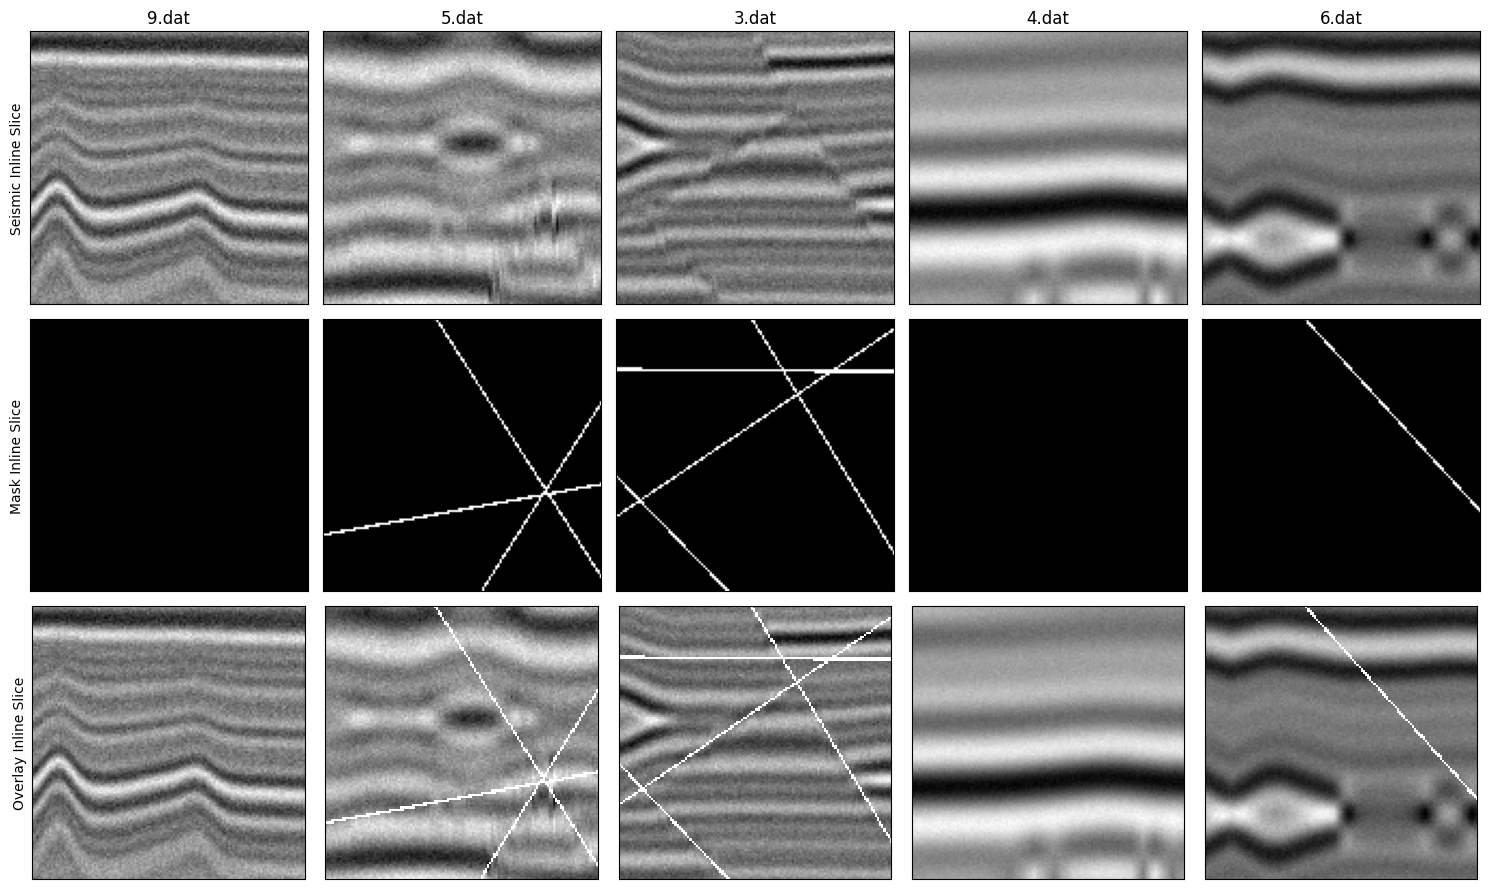

In [15]:
# ─── 4) Plot Sample Slices (Your original plotting code) ─────────────────────────
# Ensure n_show is appropriate and there are files to show
if n_files > 0:
    n_show  = min(5, n_files)
    samples = random.sample(files, n_show)

    print(f"\nPlotting {n_show} random sample slices...")

    fig, axes = plt.subplots(3, n_show, figsize=(3*n_show, 9), squeeze=False) # Use squeeze=False for consistent axes shape

    # Prepare colormaps for sample slices
    bw_cmap             = "gray"
    overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White
    # Color standalone (black background + lines) & overlay (transparent background + lines)
    mask_color_alone_cmap   = ListedColormap([
        (0.00, 0.00, 0.00, 1.0),  # 0 → black
        (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
        (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
    ])
    mask_color_overlay_cmap = ListedColormap([
        (0,0,0,0),           # 0 → transparent
        (0.50,0.00,0.50,1),  # 1 → purple (Normal)
        (0.00,0.80,0.00,1)   # 2 → green (Inverse)
    ])
    # Determine which colormaps to use based on mask_mode parameter from notebook
    if mask_mode == 0:
        mask_alone_cmap_slice   = bw_cmap
        mask_overlay_cmap_slice = overlay_bw_cmap
    else:
        mask_alone_cmap_slice   = mask_color_alone_cmap
        mask_overlay_cmap_slice = mask_color_overlay_cmap

    overlay_alpha = 1.0


    for col, fname in enumerate(samples):
        # load
        # Handle .npz files if you switch formats
        fpath = os.path.join(seismic_dir, fname)
        mpath = os.path.join(mask_dir, fname) # Mask filename should be same

        try:
            if fname.endswith(".npy"):
                 s = np.load(fpath)
                 m = np.load(mpath)
            elif fname.endswith(".npz"):
                 s_npz = np.load(fpath)
                 m_npz = np.load(mpath)
                 s = s_npz['arr_0'] # Assumes array is saved as 'arr_0' in npz
                 m = m_npz['arr_0'] # Assumes array is saved as 'arr_0' in npz
                 s_npz.close() # Close the npz file handles
                 m_npz.close()
            elif fname.endswith(".dat"):
                 s = np.fromfile(fpath, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
                 m = np.fromfile(mpath, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))
            else:
                 print(f"Skipping unknown file format for sample: {fname}")
                 continue
        except Exception as e:
             print(f"Error loading sample file {fname}: {e}")
             continue


        # Take inline slice (adjust indices if needed)
        try:
            inline      = s[s.shape[0]//2, :, :].T
            mask_inline = m[m.shape[0]//2, :, :].T
        except IndexError as e:
             print(f"Error slicing volume {fname} (shape {s.shape}): {e}")
             continue


        # Row 0: seismic
        ax = axes[0, col]
        ax.imshow(inline, cmap="gray", aspect="auto")
        ax.set_title(fname)
        if col == 0:
             ax.set_ylabel("Seismic Inline Slice")
        ax.set_xticks([])
        ax.set_yticks([])

        # Row 1: mask alone
        ax = axes[1, col]
        ax.imshow(mask_inline, cmap=mask_alone_cmap_slice, aspect="auto") # Use slice-specific cmap
        if col == 0:
            ax.set_ylabel("Mask Inline Slice")
        ax.set_xticks([])
        ax.set_yticks([])

        # Row 2: overlay
        ax = axes[2, col]
        ax.imshow(inline, cmap="gray", aspect="auto")
        ax.imshow(
            mask_inline.astype(int),
            cmap=mask_overlay_cmap_slice, # Use slice-specific cmap
            interpolation="nearest",
            alpha=overlay_alpha
        )
        if col == 0:
            ax.set_ylabel("Overlay Inline Slice")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()

else:
    print("\nNo files generated to display sample slices.")


# --- Show all plots generated in the notebook ---
plt.show()

---

---

### 3D Visualization

In [17]:
# Set data path
seismic_dir = "output/seismic"
mask_dir    = "output/mask"

# Get common files
files = sorted(set(os.listdir(seismic_dir)).intersection(set(os.listdir(mask_dir))))
selected_file = random.choice([f for f in files if f.endswith((".npy", ".dat"))])
print(f"Selected file: {selected_file}")

# Load cubes
seismic_path = os.path.join(seismic_dir, selected_file)
mask_path = os.path.join(mask_dir, selected_file)

if selected_file.endswith(".npy"):
    seismic = np.load(seismic_path)
    mask = np.load(mask_path)
elif selected_file.endswith(".dat"):
    seismic = np.fromfile(seismic_path, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
    mask = np.fromfile(mask_path, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))

Selected file: 5.dat


In [18]:
# Dimensions
nx, ny, nz = seismic.shape

In [19]:
# Extract slices
inline     = seismic[nx//2, :, :].T
crossline  = seismic[:, ny//2, :].T
timeslice  = seismic[:, :, nz//2]

inline_m   = mask[nx//2, :, :].T
cross_m    = mask[:, ny//2, :].T
timeslice_m= mask[:, :, nz//2]

In [20]:
# Normalize for 8-bit visualization
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

In [21]:
inline_norm    = normalize(inline)
crossline_norm = normalize(crossline)
timeslice_norm = normalize(timeslice)

In [22]:
## 3D plot
# Normalize for 8-bit grayscale visualization
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)


In [23]:
# Set mask_mode manually or based on your earlier config

# Start figure
fig = go.Figure()

# 1) Add the seismic grayscale slices (unchanged)
fig.add_trace(go.Surface(
    z=np.tile(np.arange(nz)[::-1], (ny, 1)).T,
    x=np.full((nz, ny), nx // 2),
    y=np.tile(np.arange(ny), (nz, 1)),
    surfacecolor=inline_norm,
    colorscale="Gray", showscale=False
))
fig.add_trace(go.Surface(
    z=np.tile(np.arange(nz)[::-1], (nx, 1)).T,
    x=np.tile(np.arange(nx), (nz, 1)),
    y=np.full((nz, nx), ny // 2),
    surfacecolor=crossline_norm,
    colorscale="Gray", showscale=False
))
fig.add_trace(go.Surface(
    z=np.full((ny, nx), nz // 2),
    x=np.tile(np.arange(nx), (ny, 1)),
    y=np.tile(np.arange(ny).reshape(-1, 1), (1, nx)),
    surfacecolor=np.rot90(timeslice_norm, k=-1),
    colorscale="Gray", showscale=False
))

# 2) Add faults based on mask_mode
def plot_fault_points(slice_mask, axis_index, slice_type, color, label):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))

if mask_mode == 0:
    # Binary faults → white
    plot_fault_points(inline_m == 1, nx // 2, "inline", "white", "Inline Faults")
    plot_fault_points(cross_m == 1, ny // 2, "crossline", "white", "Crossline Faults")
    plot_fault_points(timeslice_m == 1, nz // 2, "timeslice", "white", "Time-Slice Faults")

elif mask_mode == 1:
    # Multiclass: 1 = green, 2 = purple
    plot_fault_points(inline_m == 1, nx // 2, "inline", "green", "Inline Normal Faults")
    plot_fault_points(inline_m == 2, nx // 2, "inline", "purple", "Inline Inverse Faults")

    plot_fault_points(cross_m == 1, ny // 2, "crossline", "green", "Crossline Normal Faults")
    plot_fault_points(cross_m == 2, ny // 2, "crossline", "purple", "Crossline Inverse Faults")

    plot_fault_points(timeslice_m == 1, nz // 2, "timeslice", "green", "Time-Slice Normal Faults")
    plot_fault_points(timeslice_m == 2, nz // 2, "timeslice", "purple", "Time-Slice Inverse Faults")

# 3) Layout
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    title=f"3D Fault Visualization — {selected_file} (mask_mode={mask_mode})"
)

fig.show()


---